In [1]:
#Step 1: Import modules and connect to the database
import pandas as pd
import numpy as np
import pyodbc
import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML
config = dict(server='ABR-RIPLEYA-D1',
    port=      1433,
    database=  'neumodxRawDataDB',
    )

conn_str = ('SERVER={server};' +
            'Database={database};' +
            'TRUSTED_CONNECTION=yes')

conn = pyodbc.connect(
    r'DRIVER={SQL Server};' +
    conn_str.format(**config)
    )

In [2]:
##Step 2:  Load Consolidated Data from Gen 1.5 DB 


environment='HPV_RPT-8430_Original_Data_3'

def getSQLData_summary_coc(environment):
    query = ("Select * from [dbo].[summary_coc]"+
             " where  [Environment] like '%"+environment+"%'")
    print("Query:", query)
    df = pd.read_sql(query, conn)
    print("Length of Raw Data Frame: "+ str(len(df)))
    
    df = df.loc[~df['N500 Serial Number'].isnull()]
    print(df['N500 Serial Number'].unique())
    df.drop_duplicates(subset=['Sample ID', 'Start Date/Time'],inplace=True)
    print("Length of Filtered Data Frame: "+ str(len(df)))
    return df




OriginalData = getSQLData_summary_coc(environment)


Query: Select * from [dbo].[summary_coc] where  [Environment] like '%HPV_RPT-8430_Original_Data_3%'
Length of Raw Data Frame: 19765
['23000021' '96000005' 'N000007' 'N000012' '96000007' 'N000009']
Length of Filtered Data Frame: 5998


In [3]:
##Step 3:  Change Connection to NIMS (Gen 2) Database
from IPython.display import HTML
config = dict(server='ABR-RIPLEYA-L1',
    port=      1433,
    database=  'NIMS_New',
    )

conn_str = ('SERVER={server};' +
            'Database={database};' +
            'TRUSTED_CONNECTION=yes')

conn = pyodbc.connect(
    r'DRIVER={SQL Server};' +
    conn_str.format(**config)
    )

In [4]:
##Step 4: Get Final Data (1.9.2.6 Data processed with ADF 4.2.1) 

def get_NIMS_ChainOfCustody(trialid):
    query = "SELECT SampleTrials.SampleUId, Samples.[Sample ID], ChainOfCustodySets.[Start Date/Time] FROM ChainOfCustodySets Left JOIN SampleTrials ON SampleTrials.SampleUId=ChainOfCustodySets.SampleUId AND SampleTrials.TrialId = '"+trialid+"' Left JOIN Samples ON ChainOfCustodySets.SampleUId = Samples.UId ;"
    df = pd.read_sql(query, conn)
    return df

NIMSData = get_NIMS_ChainOfCustody('BC4699B0-DCB0-4ED2-ABCB-17628D7DEC22')

In [5]:
##Step 5: Set Index to Shared Properties between Original & NIMS Data
NIMSData.set_index(['Sample ID', "Start Date/Time"], inplace=True)
OriginalData.set_index(['Sample ID', "Start Date/Time"], inplace=True)

In [6]:
##Step 6: Combined Original Data and NIMS Data so that ChainOfCustodyInfo has SampleUID Column
ChainOfCustodyInfo = NIMSData.join(OriginalData)

In [7]:
consumables_list = ['Capture Plate Barcode',
 'Buffer Barcode',
 'Test Strip NeuMoDx Barcode',
 'Pcr Cartridge Barcode',
 'Release Reagent Barcode',
 'Wash Reagent Barcode']

for col in consumables_list:
    ChainOfCustodyInfo[col.replace('Barcode', 'Lot')] = ChainOfCustodyInfo[col].str[18:24]
    ChainOfCustodyInfo[col.replace('Barcode', 'Serial')] = ChainOfCustodyInfo[col].str[27:32]

In [8]:
[x for x in ChainOfCustodyInfo if "Software" in x]

['Software Version', 'Hamilton Software Version']

In [9]:
ChainOfCustodyInfo = ChainOfCustodyInfo[['SampleUId', 'Test Guid', 'Software Version', 'Assay Version', 'N500 Serial Number', 'PCR Module Serial', 'Pcr Cartridge Lane', 'Pcr Cartridge Barcode']+
                   [x.replace('Barcode', 'Lot') for x in consumables_list]+
                   [x.replace('Barcode', 'Serial') for x in consumables_list]]

In [10]:
ChainOfCustodyInfo

SampleUId  \
Sample ID Start Date/Time                                                     
-20Neg41  2022-04-26 08:26:01.2280000  CABABF65-F035-44F2-BAA6-EC3CE6A94E35   
          2022-04-26 08:37:59.4870000  8161D78C-752C-4375-A4BE-AA0023AB3ECB   
          2022-04-26 10:12:29.9890000  8BA9C6FD-CAE0-4161-AB14-2F08F979E76A   
-20Neg42  2022-04-26 08:26:01.2790000  0F98720E-2559-45BC-9978-7F1266CD4DC7   
          2022-04-26 08:37:59.5340000  860F5A70-D7B8-4D3A-98F6-0E12372999B5   
...                                                                     ...   
ZAS-00422 2022-04-26 15:36:10.6210000  0144198D-7F4A-4306-9CA7-BFB25363FD0B   
ZAS-00423 2022-04-26 15:40:32.8270000  46289EC2-7CE2-418B-88EA-2E487BF141A1   
ZAS-00425 2022-04-26 15:40:32.8740000  A10C5416-1877-4EDC-9094-F51740859687   
ZAS-00426 2022-04-26 15:40:32.9180000  F5B3CBA1-7025-47DE-B590-943BE3D7BCBB   
ZAS-00427 2022-04-26 15:40:32.9560000  FFD9F9E5-CF24-430F-87B1-AD6D78E8AD25   

                                                                  Test Guid  \
Sample ID Start Date/Time                                                     
-20Neg41  2022-04-26 08:26:01.2280000  3430b4bc-29c5-ec11-85fa-5cf370923501   
          2022-04-26 08:37:59.4870000  e3c17269-2bc5-ec11-85fa-5cf370923501   
          2022-04-26 10:12:29.9890000  8fd6549d-38c5-ec11-85fa-5cf370923501   
-20Neg42  2022-04-26 08:26:01.2790000  3d30b4bc-29c5-ec11-85fa-5cf370923501   
          2022-04-26 08:37:59.5340000  ecc17269-2bc5-ec11-85fa-5cf370923501   
...                                                                     ...   
ZAS-00422 2022-04-26 15:36:10.6210000  ef4ddbd4-65c5-ec11-85fa-5cf370923501   
ZAS-00423 2022-04-26 15:40:32.8270000  814c3871-66c5-ec11-85fa-5cf370923501   
ZAS-00425 2022-04-26 15:40:32.8740000  8a4c3871-66c5-ec11-85fa-5cf370923501   
ZAS-00426 2022-04-26 15:40:32.9180000  934c3871-66c5-ec11-85fa-5cf370923501   
ZAS-00427 2022-04-26 15:40:32.9560000  9c4c3871-66c5-ec11-85fa-5cf370923501   

                                      Software Version Assay Version  \
Sample ID Start Date/Time                                              
-20Neg41  2022-04-26 08:26:01.2280000          1.9.2.6         4.2.1   
          2022-04-26 08:37:59.4870000          1.9.2.6         4.2.1   
          2022-04-26 10:12:29.9890000          1.9.2.6         4.2.1   
-20Neg42  2022-04-26 08:26:01.2790000          1.9.2.6         4.2.1   
          2022-04-26 08:37:59.5340000          1.9.2.6         4.2.1   
...                                                ...           ...   
ZAS-00422 2022-04-26 15:36:10.6210000          1.9.2.6         4.2.1   
ZAS-00423 2022-04-26 15:40:32.8270000          1.9.2.6         4.2.1   
ZAS-00425 2022-04-26 15:40:32.8740000          1.9.2.6         4.2.1   
ZAS-00426 2022-04-26 15:40:32.9180000          1.9.2.6         4.2.1   
ZAS-00427 2022-04-26 15:40:32.9560000          1.9.2.6         4.2.1   

                                      N500 Serial Number PCR Module Serial  \
Sample ID Start Date/Time                                                    
-20Neg41  2022-04-26 08:26:01.2280000           96000007              V104   
          2022-04-26 08:37:59.4870000           96000007              V153   
          2022-04-26 10:12:29.9890000           96000007              V104   
-20Neg42  2022-04-26 08:26:01.2790000           96000007              V104   
          2022-04-26 08:37:59.5340000           96000007              V153   
...                                                  ...               ...   
ZAS-00422 2022-04-26 15:36:10.6210000           96000007              V153   
ZAS-00423 2022-04-26 15:40:32.8270000           96000007              V153   
ZAS-00425 2022-04-26 15:40:32.8740000           96000007              V153   
ZAS-00426 2022-04-26 15:40:32.9180000           96000007              V153   
ZAS-00427 2022-04-26 15:40:32.9560000           96000007              V153   

                                       Pcr Cartridge Lane 

In [11]:
##Step 7: Get Channel Data for Original Data

config = dict(server='ABR-RIPLEYA-D1',
    port=      1433,
    database=  'neumodxRawDataDB',
    )

conn_str = ('SERVER={server};' +
            'Database={database};' +
            'TRUSTED_CONNECTION=yes')

conn = pyodbc.connect(
    r'DRIVER={SQL Server};' +
    conn_str.format(**config)
    )

def getSQLData_channel_summary(environment, testGuids):
    query = ("Select * from [dbo].[channel_summary]"+
             "where  [Environment] like '%"+environment+"%'")
    print("Query:", query)
    df = pd.read_sql(query, conn)
    print("Length of Raw Data Frame: "+ str(len(df)))
    
    df.set_index('Test Guid', inplace=True)
    df = df.loc[testGuids,:]
    df.reset_index(inplace=True)
    df.drop_duplicates(['Test Guid', 'Channel'], inplace=True)
    print("Length of Filtered Data Frame: "+ str(len(df)))
    df.set_index(['Test Guid', 'Channel'],inplace=True)
    return df

ChannelDataOriginal = getSQLData_channel_summary(environment, [x for x in ChainOfCustodyInfo['Test Guid'].unique().tolist() if pd.isnull(x)==False])
ChannelDataOriginal['Localized Result'] = np.where(ChannelDataOriginal['Localized Result'].isnull(), ChannelDataOriginal['Target Result'], ChannelDataOriginal['Localized Result'])

##Step 8: Subset ChannelDataOriginal to include only fields that are relavant to describing the amplification state.
ChannelDataOriginal = ChannelDataOriginal[['Localized Result', 'Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Baseline First Cycle', 'Baseline Last Cycle', 'Baseline Slope']]


Query: Select * from [dbo].[channel_summary]where  [Environment] like '%HPV_RPT-8430_Original_Data_3%'
Length of Raw Data Frame: 76680
Length of Filtered Data Frame: 21536


In [12]:
##Step 9: Merge together ChainOfCustodyInfo with ChannelDataOriginal for one common dataframe to combine with the Line Data.
ChainOfCustodyInfo.dropna(subset=['Test Guid'],inplace=True)
ChainOfCustodyInfo.drop_duplicates('Test Guid',inplace=True)
OriginalDataAll = ChannelDataOriginal.join(ChainOfCustodyInfo.set_index('Test Guid'))

In [13]:
##Step 10: Rename Channels in OriginalDataAll for merge with Line Data, annotate other columns to distinguish them as "Original" Columns
OriginalDataAll = OriginalDataAll.reset_index().replace({'Green':'Green_470_510',
                                                         'Yellow':'Yellow_530_555',
                                                         'Red':'Red_625_660',
                                                         'Orange':'Orange_585_610'}).set_index(['SampleUId','Channel'])
for col in OriginalDataAll.columns:
    OriginalDataAll.rename({col:'Original '+col}, axis=1, inplace=True)

In [19]:
##Step 11: Read LineData from CSV, Merge with OriginalDataAll, and Export to CSV.
lineData = pd.read_csv('P:/Users/Aaron/HPV Data Analysis/RPT-8430_CompiledData_Final.csv')#.set_index(["Sample ID", 'StartDateTime'],inplace=True)
lineData.rename({'SampleID':'Sample ID', 'StartDateTime':'Start Date/Time'}, axis=1, inplace=True)
lineData.reset_index(inplace=True)
lineData['SampleUId'] = lineData['SampleUId'].str.upper()
lineData.set_index(['SampleUId','Channel'],inplace=True)

FinalData = lineData.join(OriginalDataAll, rsuffix='_Original')
FinalData = FinalData[~FinalData['Original N500 Serial Number'].isnull()]
FinalData.to_csv('RPT_8430_FinalData_with_OriginalData.csv')


KeyError: "None of ['Channel'] are in the columns"

In [23]:
FinalData = FinalData.reset_index().set_index(['Channel', 'ProcessingStep'])

In [21]:
def checkCartridgeNeighbors(data, cartridgeField='CartridgeId', cartridgeLaneField='PcrCartridgeLane', resultField='LocalizedResult'):
    """
    Finds and returns the specified field result associated from the neighboring cartridge lanes (left & right) of each sample included in the DataFrame.
    Parameters
    ----------
    data: pandas.DataFrame
        Pandas Dataframe used as input.
    cartridgeField: str
        Field used to identify the NeuMoDx Cartridge used for processing in data.
    cartridgeLaneField: str
        Field used to identify the Cartridge Lane used for sample processing in data.
    resultField: str
        Field value to return from Neighboring Lanes.
    """

    ##Determine Original Index
    original_index = data.index.names
    

    ##Reset Index (to ensure index is always common no matter what input).
    data.reset_index(inplace=True)

    ##Add "LeftNeighbor" & "RightNeighbor" Result Columns
    data.loc[:, 'LeftNeighbor'+resultField] = np.nan
    data.loc[:, 'RightNeighbor'+resultField] = np.nan

    for idx in data.index:

        ##Get Cartridge Barcode & Lane:
        cartridgeid = data.loc[idx, cartridgeField]
        lane = data.loc[idx, cartridgeLaneField]
        channel = data.loc[idx, 'Channel']


        ##Find Left Cartridge Neighbor & Get Result:
        leftNeighbor = data.loc[((data[cartridgeField]==cartridgeid)&
                                           (data[cartridgeLaneField]==lane-1)&
                                           (data['Channel']==channel)),:]
        
        if len(leftNeighbor)>0:
            leftNeighborResult = leftNeighbor[resultField].values[0]
        else:
            leftNeighborResult = np.nan

        ##Find Right Cartridge Neighbor & Get Result:

        rightNeighbor = data.loc[((data[cartridgeField]==cartridgeid)&
                                           (data[cartridgeLaneField]==lane+1)&
                                           (data['Channel']==channel)),:]
        
        if len(rightNeighbor)>0:
            rightNeighborResult = rightNeighbor[resultField].values[0]
        else:
            rightNeighborResult = np.nan
        
        ##Fill in LeftNeighbor and RightNeighbor Results into appropriate DataFrame Columns
        data.loc[idx, 'LeftNeighbor'+resultField] = leftNeighborResult
        data.loc[idx, 'RightNeighbor'+resultField] = rightNeighborResult

    data.set_index(original_index, inplace=True)
    return data


In [24]:
##Step 12: Get Yellow Data from Final Data (filter Data Frame to make more reasonable size)

YellowData = FinalData.loc[['Yellow_530_555'],:]

In [25]:
#Step 13: Get Results of Cartridge Neighbors for YellowData
YellowData = checkCartridgeNeighbors(YellowData, cartridgeField='Original Pcr Cartridge Barcode', cartridgeLaneField='Original Pcr Cartridge Lane')
YellowData['Has Neighboring Positive'] = np.where(((YellowData['LeftNeighborLocalizedResult']=='TargetAmplified')|(YellowData['RightNeighborLocalizedResult']=='TargetAmplified')), "Yes", "No")


In [26]:
##Step 14: Add "Year" Column for YellowData 
YellowData['Start Date/Time'] = YellowData['Start Date/Time'].astype('datetime64[ns]')
YellowData['Year'] = YellowData['Start Date/Time'].dt.year
YellowData = YellowData[~YellowData['Original N500 Serial Number'].isnull()]

In [27]:
##Step 15: Get HPV Other Negative Frame based on Sample Prefix
YellowDataNegs = YellowData[(YellowData['Sample ID'].str[:6] == "HPVneg") |
          (YellowData['Sample ID'].str[:5] == "Bglob") |
          (YellowData['Sample ID'].str[:3] == "Neg") |
          (YellowData['Sample ID'].str[:3] == "ZAS") |
          (YellowData['Sample ID'].str[:2] == "NC") |
          (YellowData['Sample ID'].str[:5] == "HPV16") |
          (YellowData['Sample ID'].str[:5] == "SiHav") |
          (YellowData['Sample ID'].str[:5] == "HeLav") |
          (YellowData['Sample ID'].str[:4] == "A549") |
          (YellowData['Sample ID'].str[:4] == "16hv") |
          (YellowData['Sample ID'].str[:4] == "Sure") |
          (YellowData['Sample ID'].str[:5] == "37Neg") |
          (YellowData['Sample ID'].str[:5] == "HPV18") ]

In [28]:
##Step 16: Assign Condition based on Baseline Profile

conditions = [
    (YellowDataNegs['BaselineFirstCycle'] == 10.0) & (YellowDataNegs['BaselineLastCycle'] == 16.0),
    (YellowDataNegs['BaselineFirstCycle'] == 10.0) & (YellowDataNegs['BaselineLastCycle'] == 10.0),
    (YellowDataNegs['BaselineFirstCycle'] != 10.0) & (YellowDataNegs['MaxPeakHeight'] > 0),
    (YellowDataNegs['BaselineFirstCycle'] != 10.0)
    ]

# create a list of the values we want to assign for each condition
values = ['Fixed Baseline Sample', 'Single Point Normalized Sample', 'Weak Amplification Sample', 'Ct Not Called']

# create a new column and use np.select to assign values to it using our lists as arguments
YellowDataNegs['Condition'] = np.select(conditions, values)

In [29]:
##Step 17: Add in FirstDerivative of Raw Data as an additional Processing Step for YellowDataNegs.
YellowDataNegs = YellowDataNegs.reset_index().set_index(['SampleUId','ProcessingStep'])

for uid, processingstep in YellowDataNegs.loc[(slice(None), 'Raw'), :].index:
    YellowDataNegs.loc[(uid, 'FirstDerivative'), :] = YellowDataNegs.loc[(uid, processingstep), :]
    YellowDataNegs.loc[(uid, 'FirstDerivative'), ['Readings'+str(i) for i in range(1,51,1)]] = YellowDataNegs.loc[(uid, 'FirstDerivative'), ['Readings'+str(i) for i in range(1,51,1)]].diff()

In [30]:
def amplificationPlot(data, colField='Channel', rowField='ProcessingStep', colorField='PcrCartridgeLane', plotwidth=20, plotheight=10, row_order=None, color_order=None, col_order=None, share_y_axis='row'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.lines import Line2D
    """
    Plots amplification curves from input Data Frame on an array of subplots.
    Parameters
    ----------
    data: pandas.DataFrame
        Pandas Dataframe used as input.
    colField: str
        Field in data to use to define to which column to plot an amplification curve.
    rowField: str
        Field in data to use to define to which row to plot an amplification curve.
    colorField: str
        Field in data to use to define to which color to use when plotting an amplification curve.
    plotwidth int
        Width to use for figure that is returned.
    plotheight int
        Height to use for figure that is returned.
    roworder: list 
        Order / Values to plot when determining the row order.
    color_order: list 
        Order / Values to plot when determining the color order.
    col_order: list
        Order / Values to plot when determining the column order.
    share_y_axis: str, bool
        Options: "Row": Share across plot row, True: Share across entire plot.
    """
    ##Define Color Dictionary to use for PCR curves & other plots for up to 36 categories
    ColorDict36  = {1:'#FF0000',#Red 1
                2:'#00B050',#Green 2
                3:'#0070C0',#Blue 3
                4:'#7030A0',#Purple 4
                5:'#808080',#Light Grey 5
                6:'#FF6600',#Orange 6
                7:'#FFCC00',#Yellow 7
                8:'#9999FF',#Light Purple 8
                9:'#333333',#Black 9
                10:'#808000',#Goldish 10
                11:'#FF99CC',#Hot Pink 11
                12:'#003300',#Dark Green 12
                13:'#FF0000',#Red 1
                14:'#00B050',#Green 2
                15:'#0070C0',#Blue 3
                16:'#7030A0',#Purple 4
                17:'#808080',#Light Grey 5
                18:'#FF6600',#Orange 6
                19:'#FFCC00',#Yellow 7
                20:'#9999FF',#Light Purple 8
                21:'#333333',#Black 9
                22:'#808000',#Goldish 10
                23:'#FF99CC',#Hot Pink 11
                24:'#003300',#Dark Green 12  
                25:'#FF0000',#Red 1
                26:'#00B050',#Green 2
                27:'#0070C0',#Blue 3
                28:'#7030A0',#Purple 4
                29:'#808080',#Light Grey 5
                30:'#FF6600',#Orange 6
                31:'#FFCC00',#Yellow 7
                32:'#9999FF',#Light Purple 8
                33:'#333333',#Black 9
                34:'#808000',#Goldish 10
                35:'#FF99CC',#Hot Pink 11
                36:'#003300',#Dark Green 12  
                }

    styleDict36 = {1: 'solid',
                2: 'solid',
                3: 'solid',
                4: 'solid',
                5: 'solid',
                6: 'solid',
                7: 'solid',
                8: 'solid',
                9: 'solid',
                10: 'solid',
                11: 'solid',
                12: 'solid',
                13: 'dashed',
                14: 'dashed',
                15: 'dashed',
                16: 'dashed',
                17: 'dashed',
                18: 'dashed',
                19: 'dashed',
                20: 'dashed',
                21: 'dashed',
                22: 'dashed',
                23: 'dashed',
                24: 'dashed',
                25: 'dashdot',
                26: 'dashdot',
                27: 'dashdot',
                28: 'dashdot',
                29: 'dashdot',
                30: 'dashdot',
                31: 'dashdot',
                32: 'dashdot',
                33: 'dashdot',
                34: 'dashdot',
                35: 'dashdot',
                36: 'dashdot'}

    plotFrame = data.reset_index()[[colField, rowField, colorField]+["Readings"+str(i) for i in range(1,51)]]
    plotFrame.loc[:, [colField, rowField, colorField]] = plotFrame.loc[:, [colField, rowField, colorField]].fillna('')
    col_groups = sorted(plotFrame[colField].unique().tolist())
    

    if col_order == None:
        col_groups = sorted(plotFrame[colField].unique().tolist())
    else:
        col_groups = col_order
        plotFrame = plotFrame[plotFrame[colField].isin(col_groups)]

    if row_order == None:
        row_groups = sorted(plotFrame[rowField].unique().tolist())
    else:
        row_groups = row_order
        plotFrame = plotFrame[plotFrame[rowField].isin(row_groups)]

    if color_order == None:
        color_groups = sorted(plotFrame[colorField].unique().tolist())
    else:
        color_groups = color_order
        plotFrame = plotFrame[plotFrame[colorField].isin(color_groups)]

    fig, axs = plt.subplots(len(row_groups), len(col_groups)+1, figsize=(plotwidth, plotheight),sharey=share_y_axis, sharex="col")

    for idx in plotFrame.index:
        X = np.arange(1,51,1)
        Y = plotFrame.loc[idx, ["Readings"+str(i) for i in range(1,51)]]
        col = plotFrame.loc[idx, colField]
        row = plotFrame.loc[idx, rowField]
        color = plotFrame.loc[idx, colorField]
        sns.lineplot(x=X, y=Y, color=ColorDict36[color_groups.index(color)+1], linestyle=styleDict36[color_groups.index(color)+1], ax=axs[row_groups.index(row), col_groups.index(col)])

    for col_idx in range(0,len(col_groups)):
        axs[0, col_idx].set_title(col_groups[col_idx], fontsize=12)

    for row_idx in range(0, len(row_groups)):
        axs[row_idx, 0].set_ylabel(row_groups[row_idx],fontsize=12)
        axs[row_idx,len(col_groups)].axis('Off')

    legend_elements = []
    for color in color_groups:
        newLabel = Line2D([0], [0], color=ColorDict36[color_groups.index(color)+1], linestyle=styleDict36[color_groups.index(color)+1], lw=3,label=color)
        legend_elements.append(newLabel)

    axs[0, len(col_groups)].legend(handles=legend_elements, fontsize=12, loc='upper left', ncol=1, title=colorField)
    
    return fig

    


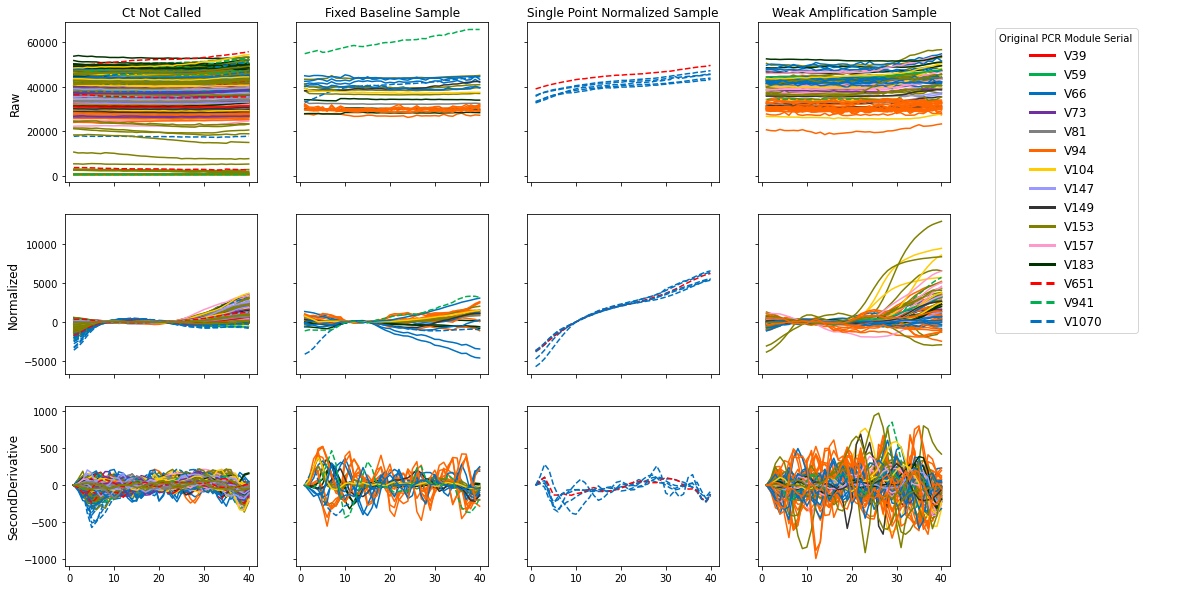

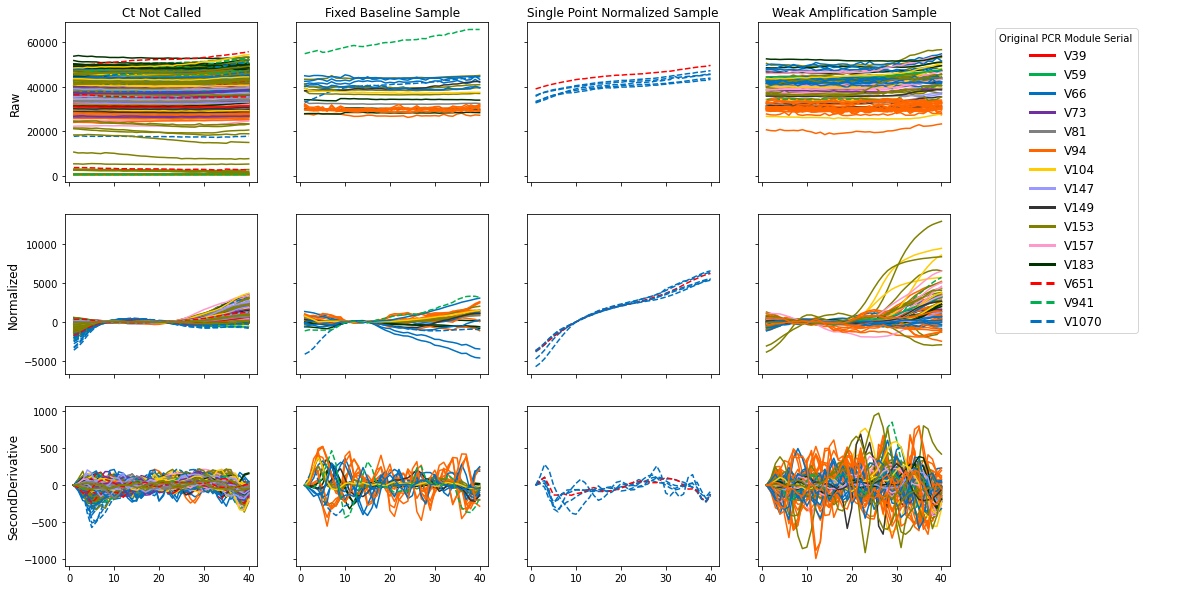

In [31]:
##Step 18: Visualize YellowDataNeg Raw, Normalized & Second Derivative Amplification Curves Organizing by Condition Assignment.
mods = sorted(YellowDataNegs['Original PCR Module Serial'].dropna().unique(), key= lambda x: int(x.replace("V", "").replace("EXP", "").replace("R", "")))

amplificationPlot(YellowDataNegs,
                  colField='Condition',
                  rowField='ProcessingStep',
                  colorField='Original PCR Module Serial',
                  plotwidth=20,
                  plotheight=10,
                  col_order=['Ct Not Called', 'Fixed Baseline Sample', 'Single Point Normalized Sample', 'Weak Amplification Sample'],
                  row_order=['Raw', 'Normalized', 'SecondDerivative'], 
                  color_order=mods)


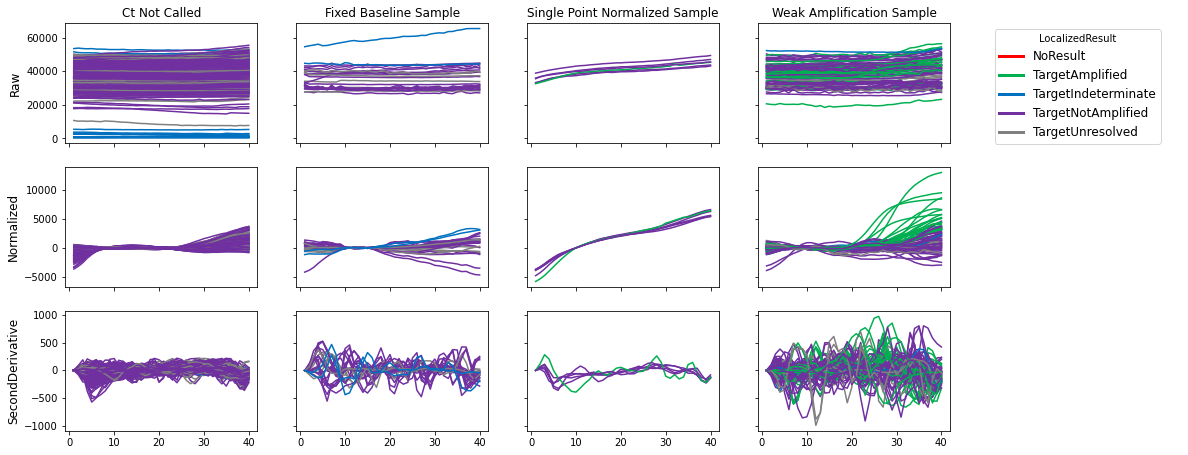

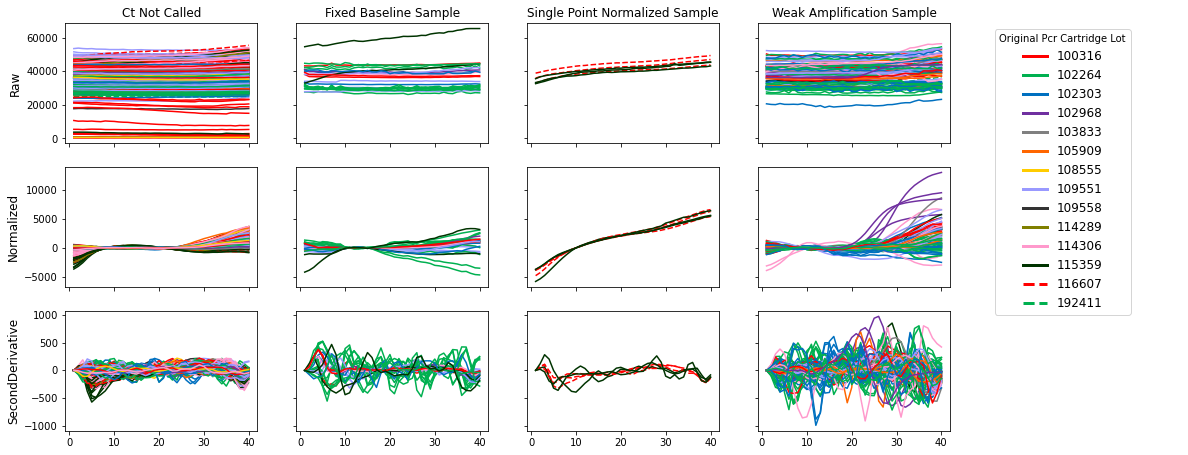

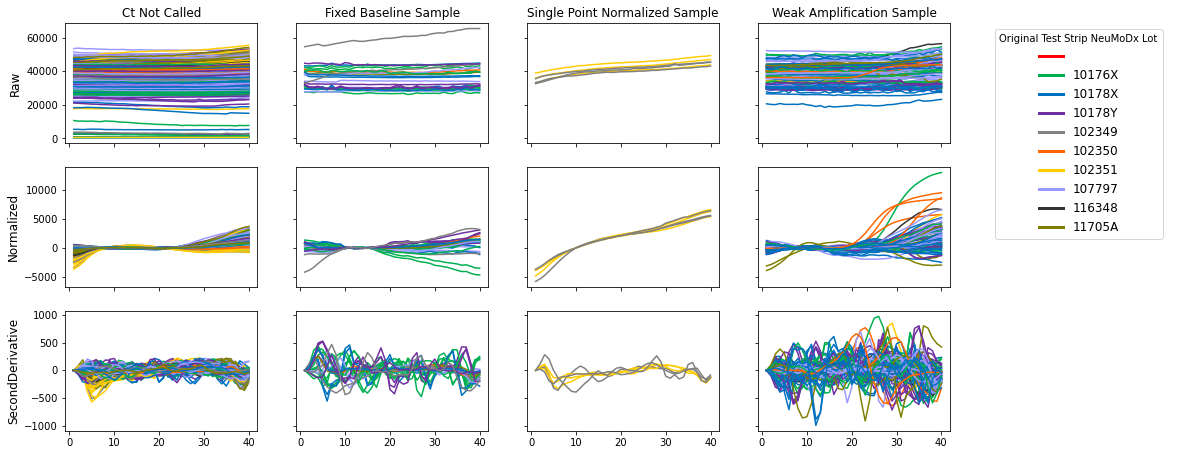

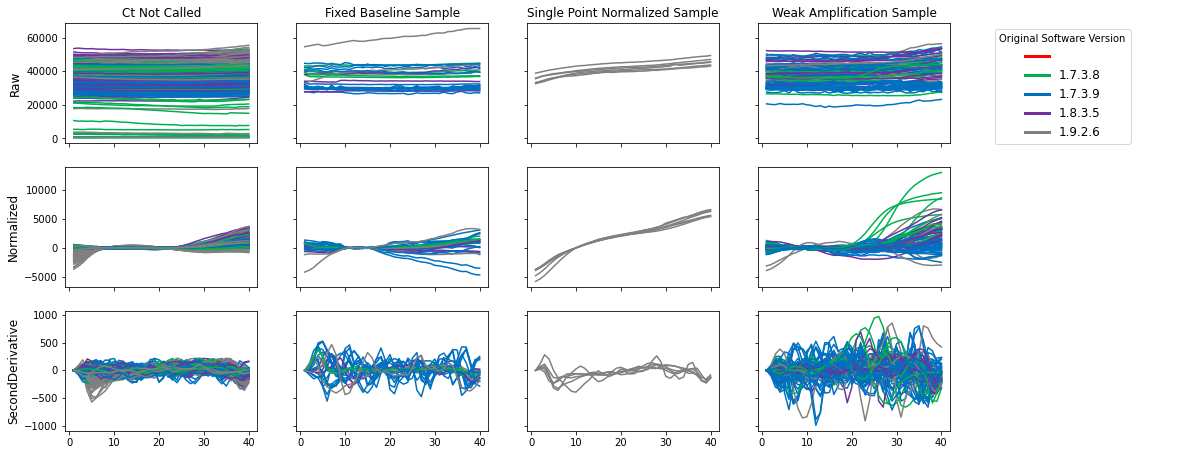

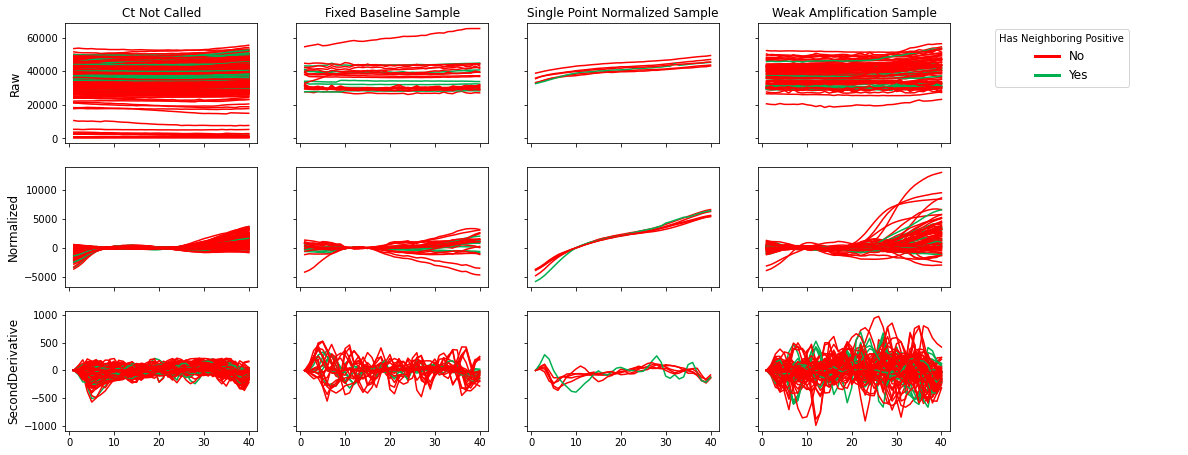

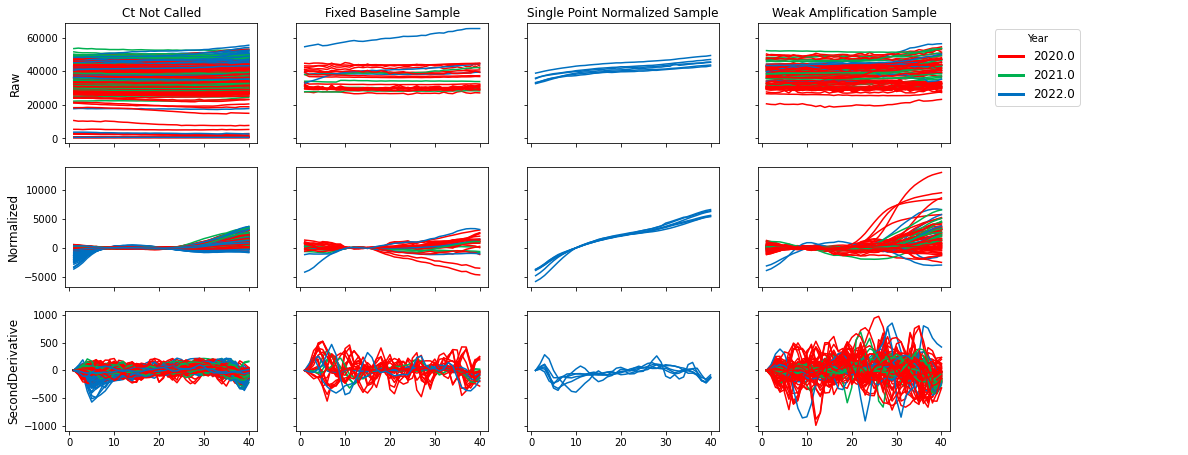

In [32]:
plotList = ['LocalizedResult', 'Original Pcr Cartridge Lot', 'Original Test Strip NeuMoDx Lot', 'Original Software Version', 'Has Neighboring Positive', 'Year']
for group in plotList:
    amplificationPlot(YellowDataNegs.reset_index().set_index('Original PCR Module Serial'),
                  colField='Condition',
                  rowField='ProcessingStep',
                  colorField=group,
                  plotwidth=20,
                  plotheight=7.5,
                  col_order=['Ct Not Called', 'Fixed Baseline Sample', 'Single Point Normalized Sample', 'Weak Amplification Sample'],
                  row_order=['Raw', 'Normalized', 'SecondDerivative'],
                  )

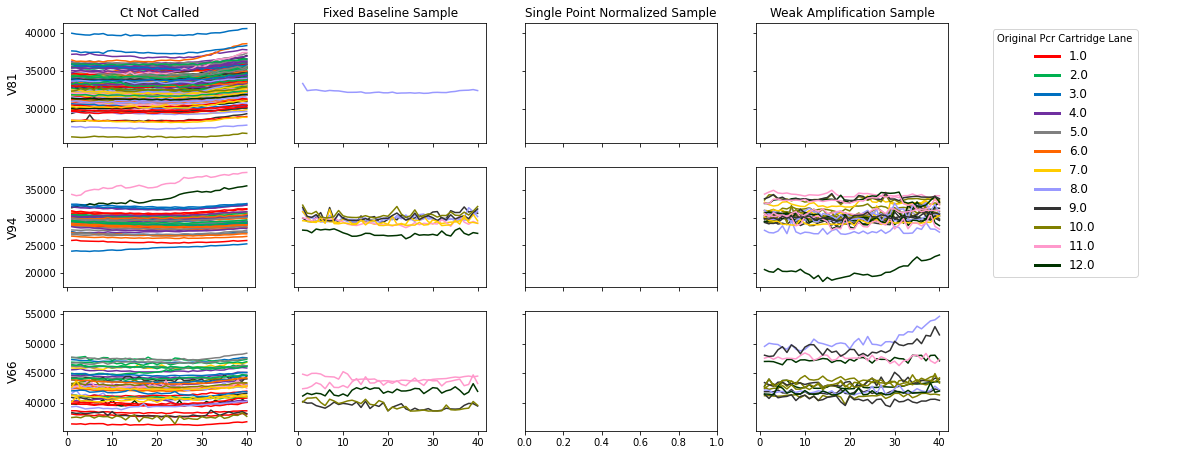

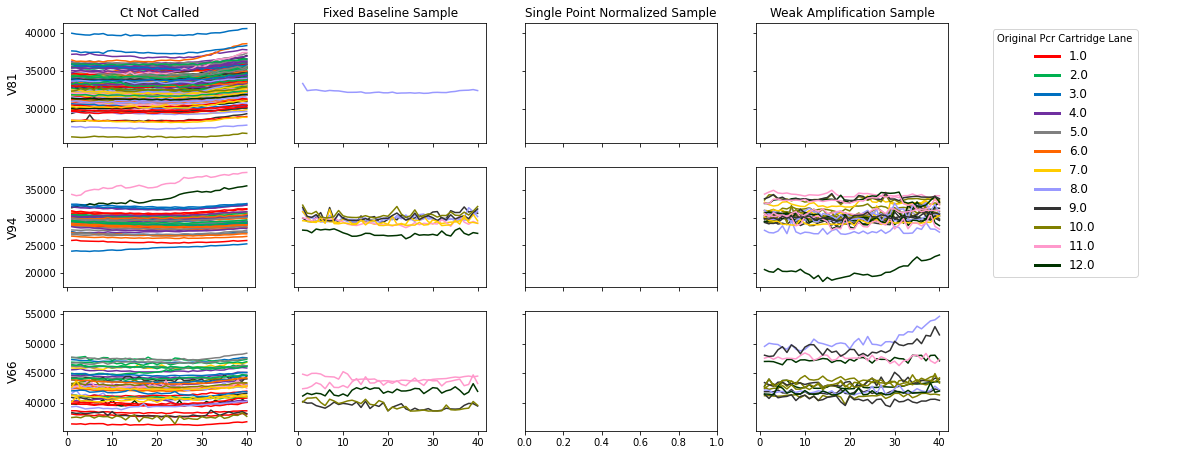

In [33]:
##Step 19 Perform BoB / WoW for XPCR Modules to compare Weak Amplification Frequency
##Step 19A: Plot Raw Data for V81, V94 & V66
amplificationPlot(YellowDataNegs.reset_index().set_index('ProcessingStep').loc['Raw'],
                  colField='Condition',
                  rowField='Original PCR Module Serial',
                  colorField='Original Pcr Cartridge Lane',
                  plotwidth=20,
                  plotheight=7.5,
                  col_order=['Ct Not Called', 'Fixed Baseline Sample', 'Single Point Normalized Sample', 'Weak Amplification Sample'],
                  row_order=['V81', 'V94', 'V66'],
                  )


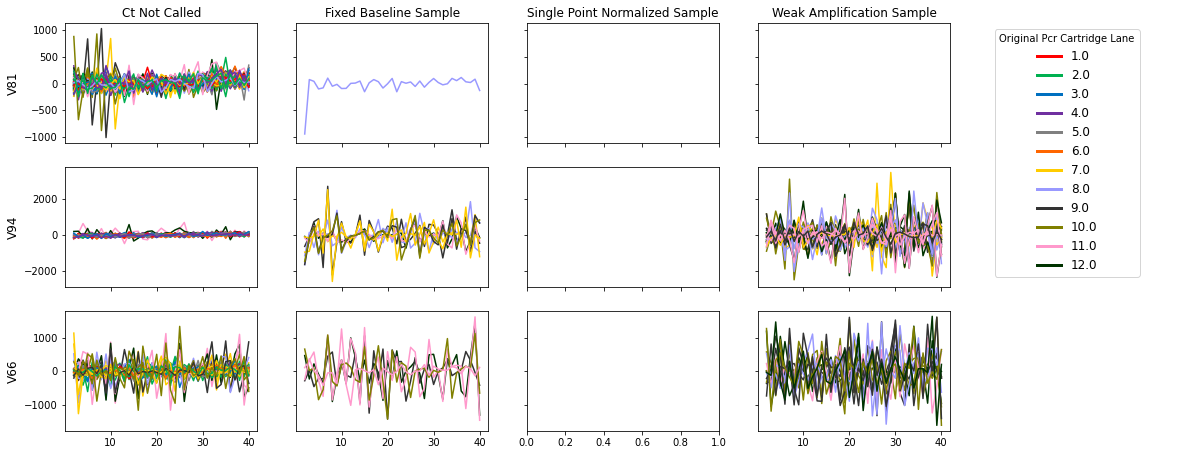

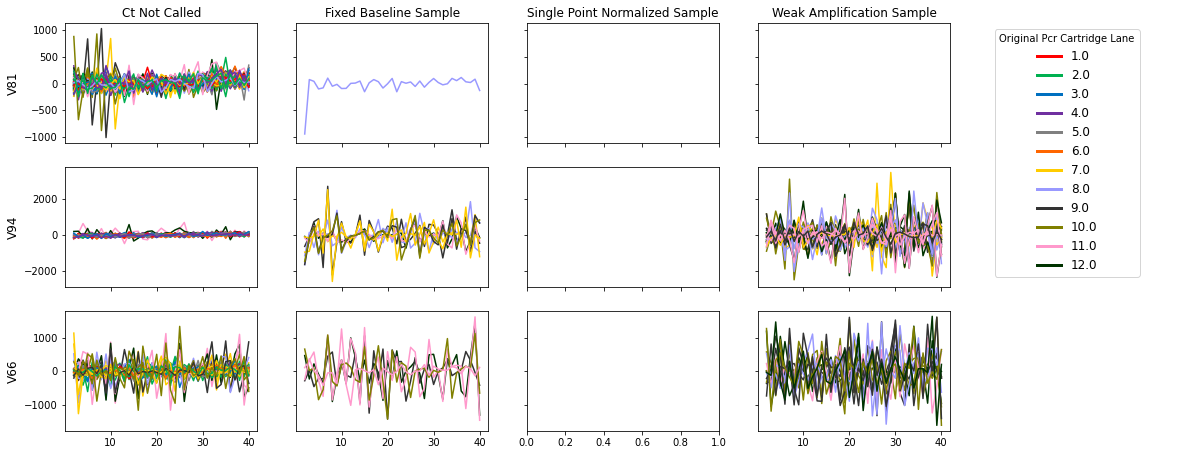

In [34]:
#Step 19B: Plot FirstDerivativeData for V81, V94 & V66
amplificationPlot(YellowDataNegs.reset_index().set_index('ProcessingStep').loc['FirstDerivative'],
                  colField='Condition',
                  rowField='Original PCR Module Serial',
                  colorField='Original Pcr Cartridge Lane',
                  plotwidth=20,
                  plotheight=7.5,
                  col_order=['Ct Not Called', 'Fixed Baseline Sample', 'Single Point Normalized Sample', 'Weak Amplification Sample'],
                  row_order=['V81', 'V94', 'V66'],
                  )

Text(0.5, 1.0, 'Ct Not Called Samples - First Derivative Readings Cycles 17-40')

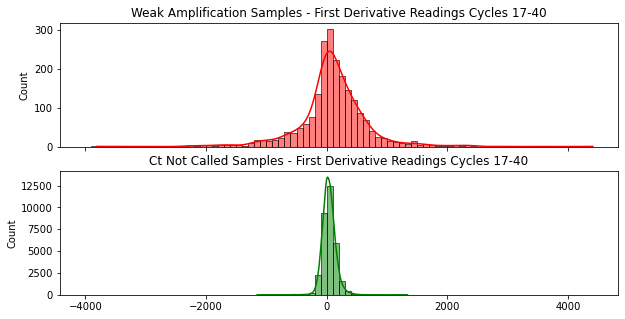

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
#Step 20: Plot / Compare First Derivative Readings from Cycles 17-40 (inside "valid cycle range") for YellowDataNegs 
#if YellowDataNegs.index.names[0]!='index':
    #YellowDataNegs.reset_index(inplace=True)
WeakAmpFirstDerivativeReadings = np.empty(shape=[1,0])
for x in YellowDataNegs[((YellowDataNegs['Condition']=='Weak Amplification Sample')&
                         (YellowDataNegs['ProcessingStep']=='FirstDerivative'))].index:
    FirstDerivativeReadings = YellowDataNegs.loc[x, ['Readings'+str(i) for i in range(17,41)]].values
    
    if WeakAmpFirstDerivativeReadings.size==0:
        WeakAmpFirstDerivativeReadings = FirstDerivativeReadings
    else:
        WeakAmpFirstDerivativeReadings = np.concatenate((WeakAmpFirstDerivativeReadings, FirstDerivativeReadings))


NoCtCalledReadings = np.empty(shape=[1,0])
for x in YellowDataNegs[((YellowDataNegs['Condition']=='Ct Not Called')&
                          (YellowDataNegs['ProcessingStep']=='FirstDerivative'))].index:
    FirstDerivativeReadings = YellowDataNegs.loc[x, ['Readings'+str(i) for i in range(17,41)]].values
    FirstDerivativeReadings = FirstDerivativeReadings[np.logical_not(pd.isnull(FirstDerivativeReadings))]

    if NoCtCalledReadings.size==0:
        NoCtCalledReadings = FirstDerivativeReadings
    else:
        NoCtCalledReadings = np.concatenate((NoCtCalledReadings, FirstDerivativeReadings))
    
#NoCtCalledReadings = NoCtCalledReadings[np.logical_not(np.isnan(x))]

fig, axs = plt.subplots(2,1, figsize=(10,5),sharex=True)
sns.histplot(WeakAmpFirstDerivativeReadings, binrange=(-4000,4000), binwidth=100, color='r', kde=True, ax=axs[0])
sns.histplot(NoCtCalledReadings, binrange=(-4000,4000), binwidth=100, color='g', kde=True, ax=axs[1])
axs[0].set_title('Weak Amplification Samples - First Derivative Readings Cycles 17-40')
axs[1].set_title('Ct Not Called Samples - First Derivative Readings Cycles 17-40')

In [67]:
#Step 21: Generate Summary DataFrame for First Derivative Readings in Valid Peak Range for Weak Amp & No Ct Called Groups:

SummaryDataFrame = pd.DataFrame(index=['Weak Amplification Samples', 'Ct Not Called Samples'], columns=['sample size', 'mean', 'StdDev', 'Var'])

for idx in SummaryDataFrame.index:
    if idx == 'Weak Amplification Samples':
        arr = WeakAmpFirstDerivativeReadings
    else:
        arr = NoCtCalledReadings
    SummaryDataFrame.loc[idx, 'n'] = arr.size
    SummaryDataFrame.loc[idx, 'mean'] = arr.mean()
    SummaryDataFrame.loc[idx, 'StdDev'] = arr.std()
    SummaryDataFrame.loc[idx, 'Var'] = (arr.std()**2)


SummaryDataFrame.style.format('{:.0f}')

In [89]:
##Step 22: Perform F-Test for Weak Amplification vs No Ct Called Groups (Compares Variance between Groups)

def f_test(x, y):
    import scipy
    f = (x.std()**2) / (y.std()**2) # calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

F_stat, p_value = f_test(WeakAmpFirstDerivativeReadings, NoCtCalledReadings)
print("F-Statistic: "+str(F_stat))
print("p_value: "+str(p_value))

if p_value < 0.05:
    print("Significant Difference Detected Between WeakAmpFirstDerivativeReadings & NoCtCalledReadings")
else:
    print("No Significant Difference Detected Between WeakAmpFirstDerivativeReadings & NoCtCalledReadings")


F-Statistic: 25.53216327313581
p_value: 1.1102230246251565e-16
Significant Difference Detected Between WeakAmpFirstDerivativeReadings & NoCtCalledReadings


In [107]:
##Step 23 Get Rate of Occurence Segmentation for Has Neighboring Positive
for condition in [x for x in YellowDataNegs.Condition.unique() if "Ct Not Called" not in x]:
    print(condition)
    YellowDataNegs.loc[:, condition] = np.where(YellowDataNegs.loc[:, 'Condition']==condition, 1, 0)

    
    
NeighboringPositiveFrame = YellowDataNegs.loc[YellowDataNegs['ProcessingStep']=='Raw',['Has Neighboring Positive']+['Sample ID']+
                            [x for x in YellowDataNegs.Condition.unique() if "Ct Not Called" not in x]].groupby('Has Neighboring Positive').agg({'Sample ID':['count'],
                                                                                                                                                 'Fixed Baseline Sample':['sum', 'mean'],
                                                                                                                                                 'Weak Amplification Sample':['sum', 'mean'],
                                                                                                                                                 'Single Point Normalized Sample':['sum', 'mean']})

new_columns = []
for x, y in NeighboringPositiveFrame.columns:
    if x == 'Sample ID':
        new_columns.append('Total Samples')
    else:
        new_columns.append(y.replace("sum", 'Number of ').replace("mean", "Rate of ")+" "+x)

NeighboringPositiveFrame.columns = new_columns
NeighboringPositiveFrame.style.format(subset=[x for x in NeighboringPositiveFrame.columns if "Rate" in x], formatter='{:.2%}')

Fixed Baseline Sample
Weak Amplification Sample
Single Point Normalized Sample


In [93]:
##Step 24 Report Info for False Positives
try:
    YellowDataNegs.reset_index(inplace=True)
except:
    print("No need to reset index")

FP_Frame = YellowDataNegs.loc[((YellowDataNegs['LocalizedResult']=='TargetAmplified')&
                    (YellowDataNegs['ProcessingStep']=="Raw")), ['Sample ID', 'Original Test Guid', 'TestGuid', 'Start Date/Time', 'Original N500 Serial Number', 'Original PCR Module Serial', 'SampleSpecimenType', 'Ct', 'EPR', 'MaxPeakHeight', 'EndPointFluorescence', 'BaselineFirstCycle', 'BaselineLastCycle', 'Condition']].sort_values('Start Date/Time')

FP_Frame.sort_values(['Condition', 'Sample ID', 'Start Date/Time']).rename({'TestGuid':'Reprocessed Test Guid'}, axis=1).style.format(subset=['Ct', 'EPR', 'MaxPeakHeight', 'EndPointFluorescence'], formatter='{:.2f}', na_rep='-').format(subset=['BaselineFirstCycle', 'BaselineLastCycle'], formatter='{:.0f}', na_rep='').hide_index()                  

No need to reset index


In [94]:
#Step 25 Report Info for All HPV NEG
try:
    YellowDataNegs.reset_index(inplace=True)
except:
    print("No need to reset index")

AllNegFrame = YellowDataNegs.loc[((YellowDataNegs['ProcessingStep']=="Raw")), ['Sample ID', 'Original Test Guid', 'TestGuid', 'Start Date/Time', 'Original N500 Serial Number', 'Original PCR Module Serial', 'SampleSpecimenType', 'Ct', 'EPR', 'MaxPeakHeight', 'EndPointFluorescence', 'BaselineFirstCycle', 'BaselineLastCycle', 'Condition']].sort_values('Start Date/Time')
AllNegFrame.sort_values(['Condition', 'Sample ID', 'Start Date/Time']).rename({'TestGuid':'Reprocessed Test Guid'}, axis=1).style.format(subset=['Ct', 'EPR', 'MaxPeakHeight', 'EndPointFluorescence'], formatter='{:.2f}', na_rep='-').format(subset=['BaselineFirstCycle', 'BaselineLastCycle'], formatter='{:.0f}', na_rep='').hide_index()

No need to reset index
